In [1]:
import pandas as pd
import numpy as np
import pickle
from collections import defaultdict
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor

def get_excluded_features():
    df = pd.read_csv('CodeBook-SELECT.csv')
    excluded = []

    for i in range(0, 377):
        desc = df.iloc[i]['Description']
        varname = df.iloc[i]['VarName']

        if 'ISCO' in desc or 'ISCO' in varname:
            excluded.append(varname)

        elif 'ISIC' in desc or 'ISIC' in varname:
            excluded.append(varname)

        elif 'mth' in desc or 'mth' in varname:
            excluded.append(varname)

        elif 'coded' in desc or 'coded' in varname:
            excluded.append(varname)

    return excluded

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
def get_included_numeric_columns(df):
    # Find numeric columns
    num_col = []
    for col in df.columns:
        if np.issubdtype(df[col].dtype, np.number):
            num_col.append(col)

    print('NUM COL')
    print(len(num_col))

    incl_num_cols = []
    for col in num_col:
        if not df[col].isna().sum() > 10000:
            m = df[col].mean()
            if m >= 1.0:
                if not (m > 9000.0 and m < 10000.0):
                    incl_num_cols.append(col)

                    if m > 1990.0 and m < 2020.0:
                        df[col] = df[col] - 1990.0
                        
#     df[incl_num_cols] = df[incl_num_cols].fillna(df.median().iloc[0])
    df[incl_num_cols] = df[incl_num_cols].fillna(df[incl_num_cols].median().iloc[0])
    print('ASU 1')
    print(df[incl_num_cols].isnull().values.any())
#     df[incl_num_cols] = df[incl_num_cols].fillna(df[incl_num_cols].mode())

    print('INCL COL')
    print(len(incl_num_cols))

    return df, incl_num_cols

In [3]:
def one_hot_encode(df, col_names):
    print(len(col_names))

    iter = 0
    new_cols = []
    for col in col_names:
        if( df[col].dtype == np.dtype('object')):
            dummies = pd.get_dummies(df[col],prefix=col)
            new_cols = new_cols + dummies.columns.tolist()
            df = pd.concat([df,dummies],axis=1)
            #drop the encoded column
            df.drop([col],axis = 1 , inplace=True)

            iter = iter + 1
            if (iter % 100 == 0):
                print(iter)

    return df, new_cols

In [4]:
def get_included_cat_cols(df, incl_num_cols):
    # TODO: Remove 999?

    cat_col = list(set(df.columns).difference(set(incl_num_cols)))

    print('CAT COL')
    print(len(cat_col))

    incl_cat_cols = []
    for col in cat_col:
        if 'v' in col and col != 'vet' and len(col) < 5:
            if len(df[col].unique()) < 11:
                incl_cat_cols.append(col)
        else:
            incl_cat_cols.append(col)
    # for col in cat_col:
    #     if len(df[col].unique()) < 11:
    #             incl_cat_cols.append(col)
    #     incl_cat_cols.append(col)
    
#     df[incl_cat_cols] = df[incl_cat_cols].fillna(df.mode().iloc[0])
    df[incl_cat_cols] = df[incl_cat_cols].fillna(df[incl_cat_cols].mode().iloc[0])

    print('INCL COL')
    print(len(incl_num_cols))

    print('There were {} columns before encoding categorical features'.format(df.shape[1]))
    df, incl_cat_cols = one_hot_encode(df, incl_cat_cols)
    print('There are {} columns after encoding categorical features'.format(df.shape[1]))

    return df, incl_cat_cols

In [5]:
def prepare_train(df, incl_num_cols, incl_cat_cols):
    # Drop 40% of the males to obtain balance
#     sampling_percentage = 0
    sampling_percentage = 40
    dropped_indexes = df[df['gender_r_Male'] == 1].sample(frac=float(sampling_percentage/100), random_state = 28).index

    with open('dropped_indexes_' + str(sampling_percentage) + '.pickle', 'wb') as outfile:
        # dump information to that file
        pickle.dump(dropped_indexes, outfile)

    train_df = df.drop(dropped_indexes)
    print(len(train_df))
    print(len(train_df.columns))
    train_df = train_df[incl_num_cols + incl_cat_cols]

    df = df[incl_num_cols + incl_cat_cols]
    print(len(df))
    print(len(df.columns))

    return df, train_df

In [6]:
from sklearn.model_selection import cross_val_score

def train_and_eval(df, train_df):
    X_train = train_df.drop(['job_performance'], axis=1).values
    y_train = train_df['job_performance'].values

    # from sklearn.model_selection import GridSearchCV
    # # Create the parameter grid based on the results of random search
    # param_grid = {
    #     'bootstrap': [True],
    #     'max_depth': [10, 20],
    #     'max_features': ['auto'],
    #     'min_samples_leaf': [50, 100],
    #     'min_samples_split': [100, 200],
    #     'n_estimators': [20, 50]
    # }
    # # Create a based model
    # rf = RandomForestRegressor(random_state = 40)
    # # Instantiate the grid search model
    # grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 5, n_jobs = -1, verbose = 2)
    # grid_search.fit(X_train, y_train)

    # print(grid_search.best_params_)
    # clf = grid_search.best_estimator_

    # Train the model using the training sets
#     clf = RandomForestRegressor(max_depth = 20, min_samples_leaf = 25, min_samples_split = 50, n_estimators = 100, random_state = 28)
    clf = linear_model.LinearRegression()
    # {'bootstrap': True, 'max_depth': 20, 'max_features': 'auto', 'min_samples_leaf': 50, 'min_samples_split': 100, 'n_estimators': 50}
#     print(clf.get_params())
#     clf = linear_model.LinearRegression()
    scores = cross_val_score(clf, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
    print(scores)
    
    clf.fit(X_train, y_train)

    X_train = df.drop(['job_performance'], axis=1).values
    y_train = df['job_performance'].values

    y_pred = clf.predict(X_train)

    print('Mean: ' + str(np.mean(y_pred)))
    print('Variance: ' + str(np.var(y_pred)))

    return clf, y_pred, mean_squared_error(y_train, y_pred)

In [7]:
def main_1(model_name):
    df = pd.read_csv('hw4-trainingset-gd2551.csv')
    df = df.drop(['uni', 'row'] + get_excluded_features(), axis=1)

    # Impute columns simply with mode
#     df = df.fillna(df.mode().iloc[0])

    df, incl_num_cols = get_included_numeric_columns(df)

    df, incl_cat_cols = get_included_cat_cols(df, incl_num_cols)

    df, train_df = prepare_train(df, incl_num_cols, incl_cat_cols)

    clf, df['y_pred'], mse = train_and_eval(df, train_df)

    print('MSE: ' + str(mse))

    with open(model_name, 'wb') as outfile:
        pickle.dump(clf, outfile)

    return df

In [8]:
# main_1('apa')

In [15]:
def main_2(model_name, train_cols):
    df = pd.read_csv('hw4-testset-gd2551.csv')
    df = df.drop(['uni', 'row'] + get_excluded_features(), axis=1)

    # Impute columns simply with mode
#     df = df.fillna(df.mode().iloc[0])

    df, incl_num_cols = get_included_numeric_columns(df)

    df, incl_cat_cols = get_included_cat_cols(df, incl_num_cols)

    for missing_col in list(set(train_cols).difference(set(df.columns))):
        df[missing_col] = np.zeros(24500, dtype='int')

    df = df[train_cols]
    
#     for gajelas in ['v272', 'v52', 'v135']:
#         df[gajelas] = np.zeros(24500, dtype='int')

    X_test = df.drop(['job_performance'], axis=1).values
    print(np.where(np.isnan(X_test)))
    
    for idx in set(np.where(np.isnan(X_test))[1]):
        X_test[:, idx] = np.zeros(24500, dtype='int')

    with open(model_name, 'rb') as infile:
        clf = pickle.load(infile)

    df['job_performance'] = clf.predict(X_test)

    print('Mean: ' + str(np.mean(df['job_performance'])))
    print('Variance: ' + str(np.var(df['job_performance'])))

    return df, X_test

In [10]:
# main_2('test_model.pickle', [])

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3209: DtypeWarning: Columns (50,172,255,256,257,258,268,280,376) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


NUM COL
60
ASU 1
False
INCL COL
24
CAT COL
319
INCL COL
24
There were 343 columns before encoding categorical features
277
100
200
There are 1249 columns after encoding categorical features
15002
1249
20000
1196
[-79623.15206151 -84412.77579711 -81708.62198737 -82900.32935117
 -85239.01873008 -89028.84575896 -77708.36627384 -86106.81055715
 -83901.04496982 -80732.73077533]
Mean: 2911.1861428515135
Variance: 111333.54676990121
MSE: 76340.69543157748


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1227e16a0>]],
      dtype=object)

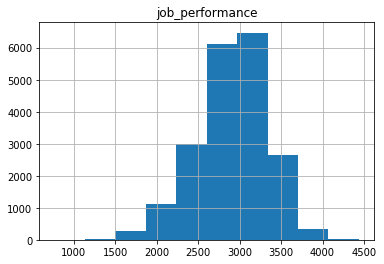

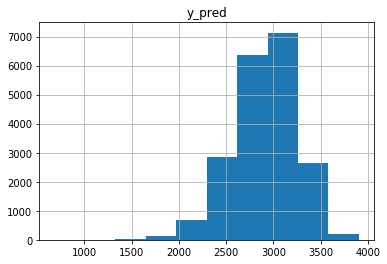

In [11]:
x = main_1('test_model.pickle')
# print('NUMS')
#     print(set(x).difference(set(a)))
# print('----')
# print(set(a).difference(set(x)))
# print('----')
#
# print('CATS')
# print(set(y).difference(set(b)))
# print('----')
# print(set(b).difference(set(y)))
# print('----')

%matplotlib inline
x.hist(column='job_performance')
x.hist(column='y_pred')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12295f0b8>]],
      dtype=object)

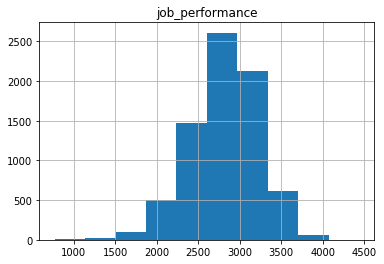

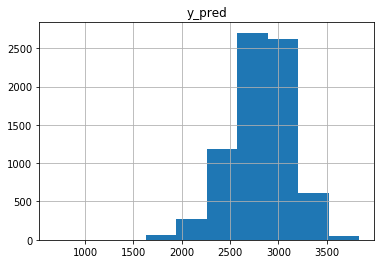

In [12]:
x[x['gender_r_Male'] == 0].hist(column='job_performance')
x[x['gender_r_Male'] == 0].hist(column='y_pred')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x122950a20>]],
      dtype=object)

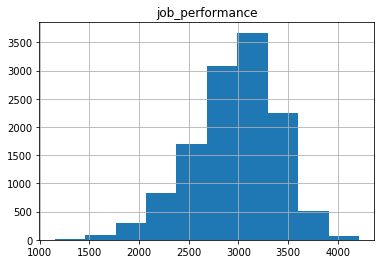

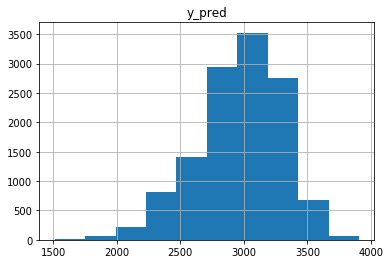

In [13]:
x[x['gender_r_Male'] == 1].hist(column='job_performance')
x[x['gender_r_Male'] == 1].hist(column='y_pred')

NUM COL
60
ASU 1
False
INCL COL
15
CAT COL
328
INCL COL
15
There were 343 columns before encoding categorical features
281
100
200
There are 1256 columns after encoding categorical features
(array([    1,     2,     2, ..., 24498, 24498, 24498]), array([22, 19, 20, ..., 19, 20, 22]))
Mean: 2077.250744395576
Variance: 246971.9754942318


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x122943fd0>]],
      dtype=object)

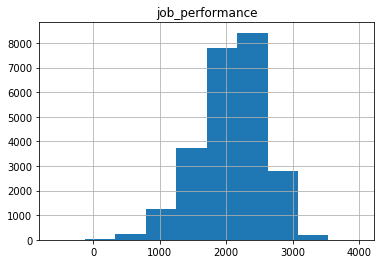

In [16]:
%matplotlib inline
a_df, a_x_test = main_2('test_model.pickle', x.drop(['y_pred'], axis=1).columns)
a_df.hist('job_performance')

In [ ]:
# print(a_df.columns[[19,20,22]])
# a_x_test[:, 22]
# print(np.count_nonzero(~np.isnan(a_x_test[:, 19])))
# print(np.count_nonzero(~np.isnan(a_x_test[:, 20])))
# print(np.count_nonzero(~np.isnan(a_x_test[:, 2])))

In [ ]:
a_df[a_df['gender_r_Male'] == 0].hist(column='job_performance')

In [ ]:
a_df[a_df['gender_r_Male'] == 1].hist(column='job_performance')

In [ ]:
# TODO: MEDIAN and SCALER
# kalo bisa regression bgs